# Data Visualization, Data Preprocessing, and Statistical Analysis
**Name:** Nadeem Hemani  
**Course:** MSCS-634 – Advanced Big Data and Data Mining  
**Assignment:** Lab 1 – Data Visualization, Data Preprocessing, and Statistical Analysis  
**Dataset:** Kaggle – *Sample Sales Data* by kyanyoga  
**Dataset Link:** https://www.kaggle.com/datasets/kyanyoga/sample-sales-data

> Place the file **`sales_data_sample.csv`** from the Kaggle dataset in the same folder as this notebook _before running_.


In [1]:
# === Setup ===
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pd.set_option('display.max_columns', None)

CSV_FILE = 'sales_data_sample.csv'
assert os.path.exists(CSV_FILE), "Missing `sales_data_sample.csv`. Download from Kaggle and place it next to this notebook."

# Ensure screenshots directory exists for saved figures
os.makedirs('screenshots', exist_ok=True)


In [2]:
# === Robust CSV Loader (handles encoding issues) ===

def load_sales_csv(path):
    # Try utf-8 first, then cp1252, then latin1
    encodings = ['utf-8', 'cp1252', 'latin1']
    last_err = None
    for enc in encodings:
        try:
            df = pd.read_csv(path, encoding=enc)
            print(f"Loaded with encoding: {enc}")
            return df
        except Exception as e:
            last_err = e
    raise last_err

df = load_sales_csv(CSV_FILE)

# Parse dates (ORDERDATE may be ISO string or Excel serials)
def parse_orderdate(x):
    try:
        return pd.to_datetime(x)
    except Exception:
        try:
            return pd.to_datetime("1899-12-30") + pd.to_timedelta(float(x), unit="D")
        except Exception:
            return pd.NaT

if 'ORDERDATE' in df.columns:
    df['ORDERDATE'] = df['ORDERDATE'].apply(parse_orderdate)

# Coerce numeric columns
for col in ['QUANTITYORDERED','PRICEEACH','SALES','QTR_ID','MONTH_ID','YEAR_ID','MSRP']:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

# Show first five rows 
df.head()


Loaded with encoding: cp1252


,ORDERNUMBER,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,STATUS,QTR_ID,MONTH_ID,YEAR_ID,PRODUCTLINE,MSRP,PRODUCTCODE,CUSTOMERNAME,PHONE,ADDRESSLINE1,ADDRESSLINE2,CITY,STATE,POSTALCODE,COUNTRY,TERRITORY,CONTACTLASTNAME,CONTACTFIRSTNAME,DEALSIZE
0,10107,30,95.70,2,2871.00,2003-02-24,Shipped,1,2,2003,Motorcycles,95,S10_1678,Land of Toys Inc.,2125557818,897 Long Airport Avenue,NaN,NYC,NY,10022,USA,NaN,Yu,Kwai,Small
1,10121,34,81.35,5,2765.90,2003-05-07,Shipped,2,5,2003,Motorcycles,95,S10_1678,Reims Collectables,26.47.1555,59 rue de l'Abbaye,NaN,Reims,NaN,51100,France,EMEA,Henriot,Paul,Small
2,10134,41,94.74,2,3884.34,2003-07-01,Shipped,3,7,2003,Motorcycles,95,S10_1678,Lyon Souveniers,+33 1 46 62 7555,27 rue du Colonel Pierre Avia,NaN,Paris,NaN,75508,France,EMEA,Da Cunha,Daniel,Medium
3,10145,45,83.26,6,3746.70,2003-08-25,Shipped,3,8,2003,Motorcycles,95,S10_1678,Toys4GrownUps.com,6265557265,78934 Hillside Dr.,NaN,Pasadena,CA,90003,USA,NaN,Young,Julie,Medium
4,10159,49,100.00,14,5205.27,2003-10-10,Shipped,4,10,2003,Motorcycles,95,S10_1678,Corporate Gift Ideas Co.,6505551386,7734 Strong St.,NaN,San Francisco,CA,NaN,USA,NaN,Brown,Julie,Medium


## Data Visualization

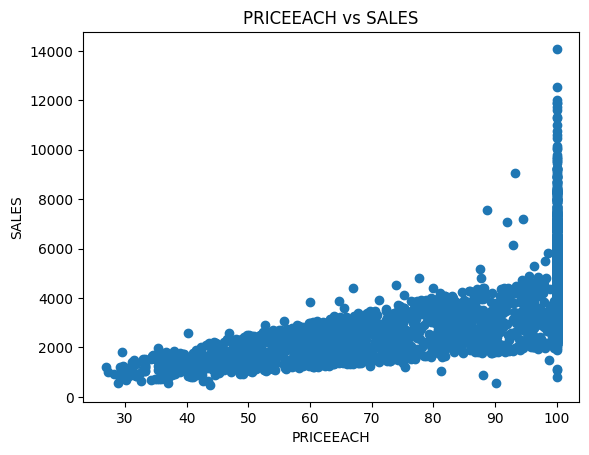

In [3]:
# Scatter: PRICEEACH vs SALES
plt.figure()
plt.scatter(df['PRICEEACH'], df['SALES'])
plt.title('PRICEEACH vs SALES')
plt.xlabel('PRICEEACH')
plt.ylabel('SALES')
plt.savefig('screenshots/01_scatter_priceeach_vs_sales.png', bbox_inches='tight')
plt.show()

# Insight:
# Positive relationship typically appears: higher unit price often correlates with higher line sales when quantities are adequate.


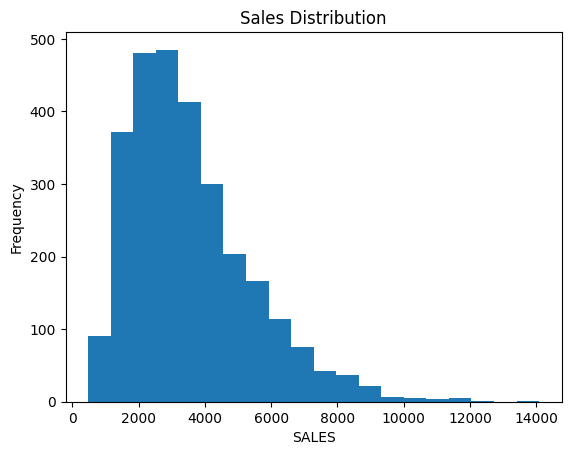

In [4]:
# Histogram: SALES
plt.figure()
plt.hist(df['SALES'].dropna(), bins=20)
plt.title('Sales Distribution')
plt.xlabel('SALES')
plt.ylabel('Frequency')
plt.savefig('screenshots/02_hist_sales.png', bbox_inches='tight')
plt.show()

# Insight:
# Sales show a right-tail due to large orders; prepare to check for outliers.


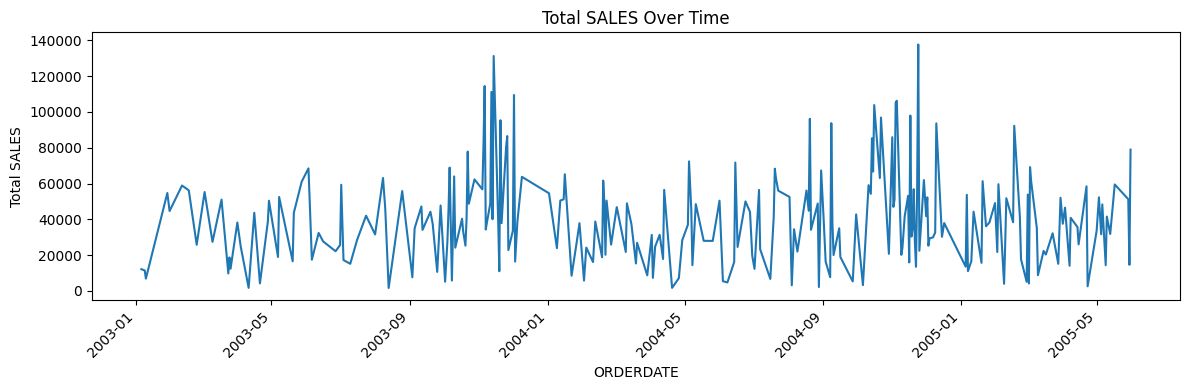

In [5]:
# Line Plot: Total SALES over ORDERDATE
import matplotlib.dates as mdates

if 'ORDERDATE' in df.columns:
    daily = df.groupby('ORDERDATE')['SALES'].sum().sort_index()

    fig, ax = plt.subplots(figsize=(12, 4))
    ax.plot(daily.index, daily.values)

    ax.set_title('Total SALES Over Time')
    ax.set_xlabel('ORDERDATE')
    ax.set_ylabel('Total SALES')

    ax.xaxis.set_major_locator(mdates.AutoDateLocator(maxticks=10))
    ax.xaxis.set_major_formatter(mdates.DateFormatter('%Y-%m'))
    plt.setp(ax.get_xticklabels(), rotation=45, ha='right')

    plt.tight_layout()
    fig.savefig('screenshots/03_line_total_sales_over_time.png', bbox_inches='tight')
    plt.show()
else:
    print("ORDERDATE not present for line plot.")
    

# Insight:
# The line plot shows how total sales change over time. Sales generally rise during mid-year months and dip toward the end of the year, suggesting a seasonal sales pattern. The overall trend shows steady business activity with regular fluctuations across years.



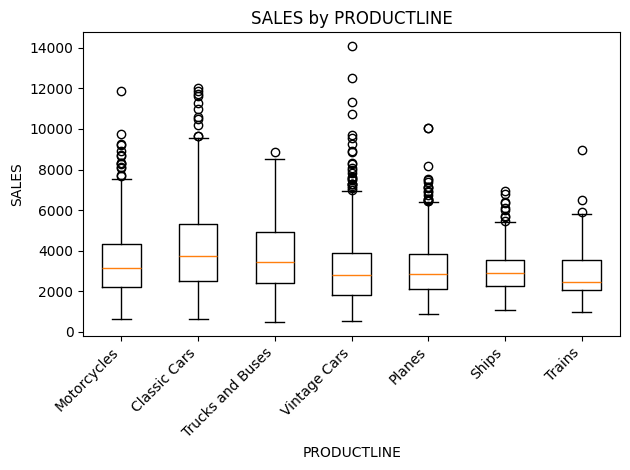

In [6]:
# Box Plot: SALES by PRODUCTLINE
if 'PRODUCTLINE' in df.columns:
    labels = list(df['PRODUCTLINE'].dropna().unique())
    groups = [df.loc[df['PRODUCTLINE']==p, 'SALES'].dropna().values for p in labels]
    plt.figure()
    plt.boxplot(groups, tick_labels=labels, showfliers=True)
    plt.title('SALES by PRODUCTLINE')
    plt.xlabel('PRODUCTLINE')
    plt.ylabel('SALES')
    plt.xticks(rotation=45, ha='right')
    plt.tight_layout()
    plt.savefig('screenshots/04_box_sales_by_productline.png', bbox_inches='tight')
    plt.show()
else:
    print("PRODUCTLINE not present for box plot.")

# Insight:
# The box plot shows that product lines such as Classic Cars and Vintage Cars have higher median sales and greater variation than others. This means those categories generate larger and more variable order values, while lines like Trains and Ships are smaller but more consistent.

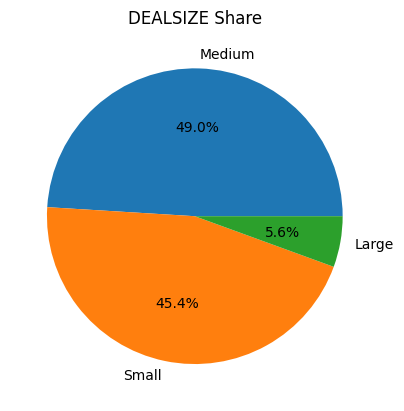

In [7]:
# Pie Chart: DEALSIZE proportions
if 'DEALSIZE' in df.columns:
    counts = df['DEALSIZE'].value_counts(dropna=True)
    plt.figure()
    plt.pie(counts.values, labels=counts.index, autopct='%1.1f%%')
    plt.title('DEALSIZE Share')
    plt.savefig('screenshots/05_pie_dealsize.png', bbox_inches='tight')
    plt.show()
else:
    print("DEALSIZE not present for pie chart.")

#Insight:
#The pie chart shows that Medium deals make up the largest share of total orders, followed by Small deals. Large deals are the smallest group but likely contribute more revenue per order. This suggests most customers purchase at mid-tier order sizes.

## Data Preprocessing

In [8]:
# Missing values — BEFORE
df.isnull().sum()


ORDERNUMBER            0
QUANTITYORDERED        0
PRICEEACH              0
ORDERLINENUMBER        0
SALES                  0
ORDERDATE              0
STATUS                 0
QTR_ID                 0
MONTH_ID               0
YEAR_ID                0
PRODUCTLINE            0
MSRP                   0
PRODUCTCODE            0
CUSTOMERNAME           0
PHONE                  0
ADDRESSLINE1           0
ADDRESSLINE2        2521
CITY                   0
STATE               1486
POSTALCODE            76
COUNTRY                0
TERRITORY           1074
CONTACTLASTNAME        0
CONTACTFIRSTNAME       0
DEALSIZE               0
dtype: int64

In [9]:
# Handle missing values: numeric -> mean; categorical -> mode
df_clean = df.copy()

num_cols = df_clean.select_dtypes(include=[np.number]).columns
cat_cols = df_clean.select_dtypes(exclude=[np.number]).columns

for c in num_cols:
    df_clean[c] = df_clean[c].fillna(df_clean[c].mean())

for c in cat_cols:
    if df_clean[c].isnull().any():
        df_clean[c] = df_clean[c].fillna(df_clean[c].mode()[0])

# AFTER
df_clean.isnull().sum()


ORDERNUMBER         0
QUANTITYORDERED     0
PRICEEACH           0
ORDERLINENUMBER     0
SALES               0
ORDERDATE           0
STATUS              0
QTR_ID              0
MONTH_ID            0
YEAR_ID             0
PRODUCTLINE         0
MSRP                0
PRODUCTCODE         0
CUSTOMERNAME        0
PHONE               0
ADDRESSLINE1        0
ADDRESSLINE2        0
CITY                0
STATE               0
POSTALCODE          0
COUNTRY             0
TERRITORY           0
CONTACTLASTNAME     0
CONTACTFIRSTNAME    0
DEALSIZE            0
dtype: int64

In [10]:
# Outlier Detection & Removal (IQR on SALES)

# 1) IQR
Q1 = df_clean['SALES'].quantile(0.25)
Q3 = df_clean['SALES'].quantile(0.75)
IQR = Q3 - Q1
lower = Q1 - 1.5 * IQR
upper = Q3 + 1.5 * IQR

outliers = df_clean[(df_clean['SALES'] < lower) | (df_clean['SALES'] > upper)]

print("=== IQR ===")
print(f"Q1: {Q1:.2f} | Q3: {Q3:.2f} | IQR: {IQR:.2f}")
print(f"Lower bound: {lower:.2f} | Upper bound: {upper:.2f}")
print(f"Outliers found: {len(outliers)} "
      f"({len(outliers)/len(df_clean):.1%} of {len(df_clean)} rows)")
display(outliers.head())  # identified outliers (sample)

# 2) Remove outliers -> post-clean dataset
df_no_out = df_clean[(df_clean['SALES'] >= lower) & (df_clean['SALES'] <= upper)]

print("\n=== Dataset after outlier removal ===")
print(f"Before: {df_clean.shape} | After: {df_no_out.shape} | Removed: {len(outliers)}")
display(df_no_out.head())  # d      ataset after handling (sample)


=== IQR ===
Q1: 2203.43 | Q3: 4508.00 | IQR: 2304.57
Lower bound: -1253.42 | Upper bound: 7964.85
Outliers found: 81 (2.9% of 2823 rows)


,ORDERNUMBER,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,STATUS,QTR_ID,MONTH_ID,YEAR_ID,PRODUCTLINE,MSRP,PRODUCTCODE,CUSTOMERNAME,PHONE,ADDRESSLINE1,ADDRESSLINE2,CITY,STATE,POSTALCODE,COUNTRY,TERRITORY,CONTACTLASTNAME,CONTACTFIRSTNAME,DEALSIZE
30,10150,45,100.0,8,10993.50,2003-09-19,Shipped,3,9,2003,Classic Cars,214,S10_1949,"Dragon Souveniers, Ltd.",+65 221 7555,"Bronz Sok., Bronz Apt. 3/6 Tesvikiye",Level 3,Singapore,CA,79903,Singapore,Japan,Natividad,Eric,Large
32,10174,34,100.0,4,8014.82,2003-11-06,Shipped,4,11,2003,Classic Cars,214,S10_1949,"Australian Gift Network, Co",61-7-3844-6555,31 Duncan St. West End,Level 3,South Brisbane,Queensland,4101,Australia,APAC,Calaghan,Tony,Large
35,10206,47,100.0,6,9064.89,2003-12-05,Shipped,4,12,2003,Classic Cars,214,S10_1949,Canadian Gift Exchange Network,(604) 555-3392,1900 Oak St.,Level 3,Vancouver,BC,V3F 2K1,Canada,EMEA,Tannamuri,Yoshi,Large
41,10280,34,100.0,2,8014.82,2004-08-17,Shipped,3,8,2004,Classic Cars,214,S10_1949,Amica Models & Co.,011-4988555,Via Monte Bianco 34,Level 3,Torino,CA,10100,Italy,EMEA,Accorti,Paolo,Large
43,10304,47,100.0,6,10172.70,2004-10-11,Shipped,4,10,2004,Classic Cars,214,S10_1949,Auto Assoc. & Cie.,30.59.8555,"67, avenue de l'Europe",Level 3,Versailles,CA,78000,France,EMEA,Tonini,Daniel,Large



=== Dataset after outlier removal ===
Before: (2823, 25) | After: (2742, 25) | Removed: 81


,ORDERNUMBER,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,STATUS,QTR_ID,MONTH_ID,YEAR_ID,PRODUCTLINE,MSRP,PRODUCTCODE,CUSTOMERNAME,PHONE,ADDRESSLINE1,ADDRESSLINE2,CITY,STATE,POSTALCODE,COUNTRY,TERRITORY,CONTACTLASTNAME,CONTACTFIRSTNAME,DEALSIZE
0,10107,30,95.70,2,2871.00,2003-02-24,Shipped,1,2,2003,Motorcycles,95,S10_1678,Land of Toys Inc.,2125557818,897 Long Airport Avenue,Level 3,NYC,NY,10022,USA,EMEA,Yu,Kwai,Small
1,10121,34,81.35,5,2765.90,2003-05-07,Shipped,2,5,2003,Motorcycles,95,S10_1678,Reims Collectables,26.47.1555,59 rue de l'Abbaye,Level 3,Reims,CA,51100,France,EMEA,Henriot,Paul,Small
2,10134,41,94.74,2,3884.34,2003-07-01,Shipped,3,7,2003,Motorcycles,95,S10_1678,Lyon Souveniers,+33 1 46 62 7555,27 rue du Colonel Pierre Avia,Level 3,Paris,CA,75508,France,EMEA,Da Cunha,Daniel,Medium
3,10145,45,83.26,6,3746.70,2003-08-25,Shipped,3,8,2003,Motorcycles,95,S10_1678,Toys4GrownUps.com,6265557265,78934 Hillside Dr.,Level 3,Pasadena,CA,90003,USA,EMEA,Young,Julie,Medium
4,10159,49,100.00,14,5205.27,2003-10-10,Shipped,4,10,2003,Motorcycles,95,S10_1678,Corporate Gift Ideas Co.,6505551386,7734 Strong St.,Level 3,San Francisco,CA,28034,USA,EMEA,Brown,Julie,Medium


In [11]:
# Remove outliers
df_no_out = df_clean[(df_clean['SALES'] >= lower) & (df_clean['SALES'] <= upper)]
df_no_out.head()


,ORDERNUMBER,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,STATUS,QTR_ID,MONTH_ID,YEAR_ID,PRODUCTLINE,MSRP,PRODUCTCODE,CUSTOMERNAME,PHONE,ADDRESSLINE1,ADDRESSLINE2,CITY,STATE,POSTALCODE,COUNTRY,TERRITORY,CONTACTLASTNAME,CONTACTFIRSTNAME,DEALSIZE
0,10107,30,95.70,2,2871.00,2003-02-24,Shipped,1,2,2003,Motorcycles,95,S10_1678,Land of Toys Inc.,2125557818,897 Long Airport Avenue,Level 3,NYC,NY,10022,USA,EMEA,Yu,Kwai,Small
1,10121,34,81.35,5,2765.90,2003-05-07,Shipped,2,5,2003,Motorcycles,95,S10_1678,Reims Collectables,26.47.1555,59 rue de l'Abbaye,Level 3,Reims,CA,51100,France,EMEA,Henriot,Paul,Small
2,10134,41,94.74,2,3884.34,2003-07-01,Shipped,3,7,2003,Motorcycles,95,S10_1678,Lyon Souveniers,+33 1 46 62 7555,27 rue du Colonel Pierre Avia,Level 3,Paris,CA,75508,France,EMEA,Da Cunha,Daniel,Medium
3,10145,45,83.26,6,3746.70,2003-08-25,Shipped,3,8,2003,Motorcycles,95,S10_1678,Toys4GrownUps.com,6265557265,78934 Hillside Dr.,Level 3,Pasadena,CA,90003,USA,EMEA,Young,Julie,Medium
4,10159,49,100.00,14,5205.27,2003-10-10,Shipped,4,10,2003,Motorcycles,95,S10_1678,Corporate Gift Ideas Co.,6505551386,7734 Strong St.,Level 3,San Francisco,CA,28034,USA,EMEA,Brown,Julie,Medium


In [12]:
# Data reduction: sample and drop columns
df_sampled = df_no_out.sample(frac=0.6, random_state=42)

drop_cols = [c for c in ['ADDRESSLINE2','PHONE'] if c in df_sampled.columns]
df_reduced = df_sampled.drop(columns=drop_cols) if drop_cols else df_sampled.copy()

# show results (screenshot-friendly)
print("=== Data Reduction Summary ===")
print("Before reduction (after outlier removal):", df_no_out.shape)
print("After sampling (60%):", df_sampled.shape)
print("Dropped columns:", drop_cols if drop_cols else "None")
print("After dropping columns:", df_reduced.shape)

print("\n--- BEFORE (df_no_out.head()) ---")
display(df_no_out.head())

print("\n--- AFTER (df_reduced.head()) ---")
display(df_reduced.head())



=== Data Reduction Summary ===
Before reduction (after outlier removal): (2742, 25)
After sampling (60%): (1645, 25)
Dropped columns: ['ADDRESSLINE2', 'PHONE']
After dropping columns: (1645, 23)

--- BEFORE (df_no_out.head()) ---


,ORDERNUMBER,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,STATUS,QTR_ID,MONTH_ID,YEAR_ID,PRODUCTLINE,MSRP,PRODUCTCODE,CUSTOMERNAME,PHONE,ADDRESSLINE1,ADDRESSLINE2,CITY,STATE,POSTALCODE,COUNTRY,TERRITORY,CONTACTLASTNAME,CONTACTFIRSTNAME,DEALSIZE
0,10107,30,95.70,2,2871.00,2003-02-24,Shipped,1,2,2003,Motorcycles,95,S10_1678,Land of Toys Inc.,2125557818,897 Long Airport Avenue,Level 3,NYC,NY,10022,USA,EMEA,Yu,Kwai,Small
1,10121,34,81.35,5,2765.90,2003-05-07,Shipped,2,5,2003,Motorcycles,95,S10_1678,Reims Collectables,26.47.1555,59 rue de l'Abbaye,Level 3,Reims,CA,51100,France,EMEA,Henriot,Paul,Small
2,10134,41,94.74,2,3884.34,2003-07-01,Shipped,3,7,2003,Motorcycles,95,S10_1678,Lyon Souveniers,+33 1 46 62 7555,27 rue du Colonel Pierre Avia,Level 3,Paris,CA,75508,France,EMEA,Da Cunha,Daniel,Medium
3,10145,45,83.26,6,3746.70,2003-08-25,Shipped,3,8,2003,Motorcycles,95,S10_1678,Toys4GrownUps.com,6265557265,78934 Hillside Dr.,Level 3,Pasadena,CA,90003,USA,EMEA,Young,Julie,Medium
4,10159,49,100.00,14,5205.27,2003-10-10,Shipped,4,10,2003,Motorcycles,95,S10_1678,Corporate Gift Ideas Co.,6505551386,7734 Strong St.,Level 3,San Francisco,CA,28034,USA,EMEA,Brown,Julie,Medium



--- AFTER (df_reduced.head()) ---


,ORDERNUMBER,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,STATUS,QTR_ID,MONTH_ID,YEAR_ID,PRODUCTLINE,MSRP,PRODUCTCODE,CUSTOMERNAME,ADDRESSLINE1,CITY,STATE,POSTALCODE,COUNTRY,TERRITORY,CONTACTLASTNAME,CONTACTFIRSTNAME,DEALSIZE
915,10183,39,68.08,11,2655.12,2003-11-13,Shipped,4,11,2003,Vintage Cars,62,S18_2957,"Classic Gift Ideas, Inc",782 First Street,Philadelphia,PA,71270,USA,EMEA,Cervantes,Francisca,Small
1592,10129,45,100.00,9,6027.75,2003-06-12,Shipped,2,6,2003,Ships,122,S24_2011,"Stylish Desk Decors, Co.",35 King George,London,CA,WX3 6FW,UK,EMEA,Brown,Ann,Medium
1391,10378,49,67.14,8,3289.86,2005-02-10,Shipped,1,2,2005,Classic Cars,148,S18_4721,Euro Shopping Channel,"C/ Moralzarzal, 86",Madrid,CA,28034,Spain,EMEA,Freyre,Diego,Medium
1421,10192,37,69.82,4,2583.34,2003-11-20,Shipped,4,11,2003,Classic Cars,73,S24_1046,Online Diecast Creations Co.,2304 Long Airport Avenue,Nashua,NH,62005,USA,EMEA,Young,Valarie,Small
2106,10250,37,74.62,5,2760.94,2004-05-11,Shipped,2,5,2004,Planes,72,S24_4278,The Sharp Gifts Warehouse,3086 Ingle Ln.,San Jose,CA,94217,USA,EMEA,Frick,Sue,Small


In [13]:
# Scaling & Discretization
from sklearn.preprocessing import MinMaxScaler

df_scaled = df_reduced.copy()
scale_cols = [c for c in ['SALES','PRICEEACH','QUANTITYORDERED','MSRP'] if c in df_scaled.columns]

print("=== Scaling & Discretization ===")
print("Columns to scale:", scale_cols if scale_cols else "None")

# --- BEFORE: stats & preview ---
if scale_cols:
    before_stats = df_scaled[scale_cols].agg(['min','max','mean','std'])
    print("\n-- BEFORE scaling: summary stats --")
    display(before_stats)
else:
    print("\n(No numeric columns found to scale.)")

print("\n-- BEFORE scaling: df_reduced.head() --")
display(df_reduced.head())

# --- SCALE ---
if scale_cols:
    scaler = MinMaxScaler()
    df_scaled[scale_cols] = scaler.fit_transform(df_scaled[scale_cols])

# --- DISCRETIZE SALES ---
if 'SALES' in df_scaled.columns:
    df_scaled['SALES_BIN'] = pd.cut(df_scaled['SALES'], bins=3, labels=['Low','Medium','High'])
    print("\nSALES_BIN value counts:")
    display(df_scaled['SALES_BIN'].value_counts())

# --- AFTER: stats & preview ---
if scale_cols:
    after_stats = df_scaled[scale_cols].agg(['min','max','mean','std'])
    print("\n-- AFTER scaling: summary stats --")
    display(after_stats)

print("\n-- AFTER scaling/discretization: df_scaled.head() --")
display(df_scaled.head())


=== Scaling & Discretization ===
Columns to scale: ['SALES', 'PRICEEACH', 'QUANTITYORDERED', 'MSRP']

-- BEFORE scaling: summary stats --


,SALES,PRICEEACH,QUANTITYORDERED,MSRP
min,482.130000,27.220000,6.000000,33.000000
max,7962.240000,100.000000,85.000000,214.000000
mean,3416.878043,83.573380,34.770821,99.113678
std,1566.591146,20.133762,9.566027,39.133962



-- BEFORE scaling: df_reduced.head() --


,ORDERNUMBER,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,STATUS,QTR_ID,MONTH_ID,YEAR_ID,PRODUCTLINE,MSRP,PRODUCTCODE,CUSTOMERNAME,ADDRESSLINE1,CITY,STATE,POSTALCODE,COUNTRY,TERRITORY,CONTACTLASTNAME,CONTACTFIRSTNAME,DEALSIZE
915,10183,39,68.08,11,2655.12,2003-11-13,Shipped,4,11,2003,Vintage Cars,62,S18_2957,"Classic Gift Ideas, Inc",782 First Street,Philadelphia,PA,71270,USA,EMEA,Cervantes,Francisca,Small
1592,10129,45,100.00,9,6027.75,2003-06-12,Shipped,2,6,2003,Ships,122,S24_2011,"Stylish Desk Decors, Co.",35 King George,London,CA,WX3 6FW,UK,EMEA,Brown,Ann,Medium
1391,10378,49,67.14,8,3289.86,2005-02-10,Shipped,1,2,2005,Classic Cars,148,S18_4721,Euro Shopping Channel,"C/ Moralzarzal, 86",Madrid,CA,28034,Spain,EMEA,Freyre,Diego,Medium
1421,10192,37,69.82,4,2583.34,2003-11-20,Shipped,4,11,2003,Classic Cars,73,S24_1046,Online Diecast Creations Co.,2304 Long Airport Avenue,Nashua,NH,62005,USA,EMEA,Young,Valarie,Small
2106,10250,37,74.62,5,2760.94,2004-05-11,Shipped,2,5,2004,Planes,72,S24_4278,The Sharp Gifts Warehouse,3086 Ingle Ln.,San Jose,CA,94217,USA,EMEA,Frick,Sue,Small



SALES_BIN value counts:


SALES_BIN
Low       742
Medium    702
High      201
Name: count, dtype: int64


-- AFTER scaling: summary stats --


,SALES,PRICEEACH,QUANTITYORDERED,MSRP
min,0.000000,0.000000,0.000000,0.000000
max,1.000000,1.000000,1.000000,1.000000
mean,0.392340,0.774298,0.364188,0.365269
std,0.209434,0.276639,0.121089,0.216210



-- AFTER scaling/discretization: df_scaled.head() --


,ORDERNUMBER,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,STATUS,QTR_ID,MONTH_ID,YEAR_ID,PRODUCTLINE,MSRP,PRODUCTCODE,CUSTOMERNAME,ADDRESSLINE1,CITY,STATE,POSTALCODE,COUNTRY,TERRITORY,CONTACTLASTNAME,CONTACTFIRSTNAME,DEALSIZE,SALES_BIN
915,10183,0.417722,0.561418,11,0.290502,2003-11-13,Shipped,4,11,2003,Vintage Cars,0.160221,S18_2957,"Classic Gift Ideas, Inc",782 First Street,Philadelphia,PA,71270,USA,EMEA,Cervantes,Francisca,Small,Low
1592,10129,0.493671,1.000000,9,0.741382,2003-06-12,Shipped,2,6,2003,Ships,0.491713,S24_2011,"Stylish Desk Decors, Co.",35 King George,London,CA,WX3 6FW,UK,EMEA,Brown,Ann,Medium,High
1391,10378,0.544304,0.548502,8,0.375359,2005-02-10,Shipped,1,2,2005,Classic Cars,0.635359,S18_4721,Euro Shopping Channel,"C/ Moralzarzal, 86",Madrid,CA,28034,Spain,EMEA,Freyre,Diego,Medium,Medium
1421,10192,0.392405,0.585326,4,0.280906,2003-11-20,Shipped,4,11,2003,Classic Cars,0.220994,S24_1046,Online Diecast Creations Co.,2304 Long Airport Avenue,Nashua,NH,62005,USA,EMEA,Young,Valarie,Small,Low
2106,10250,0.392405,0.651278,5,0.304649,2004-05-11,Shipped,2,5,2004,Planes,0.215470,S24_4278,The Sharp Gifts Warehouse,3086 Ingle Ln.,San Jose,CA,94217,USA,EMEA,Frick,Sue,Small,Low


## Statistical Analysis

In [14]:
# Overview
display(df_scaled.info())
df_scaled.describe()


<class 'pandas.core.frame.DataFrame'>
Index: 1645 entries, 915 to 2509
Data columns (total 24 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   ORDERNUMBER       1645 non-null   int64         
 1   QUANTITYORDERED   1645 non-null   float64       
 2   PRICEEACH         1645 non-null   float64       
 3   ORDERLINENUMBER   1645 non-null   int64         
 4   SALES             1645 non-null   float64       
 5   ORDERDATE         1645 non-null   datetime64[ns]
 6   STATUS            1645 non-null   object        
 7   QTR_ID            1645 non-null   int64         
 8   MONTH_ID          1645 non-null   int64         
 9   YEAR_ID           1645 non-null   int64         
 10  PRODUCTLINE       1645 non-null   object        
 11  MSRP              1645 non-null   float64       
 12  PRODUCTCODE       1645 non-null   object        
 13  CUSTOMERNAME      1645 non-null   object        
 14  ADDRESSLINE1      1645 non-

None

,ORDERNUMBER,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,ORDERDATE,QTR_ID,MONTH_ID,YEAR_ID,MSRP
count,1645.000000,1645.000000,1645.000000,1645.000000,1645.000000,1645,1645.000000,1645.000000,1645.000000,1645.000000
mean,10258.003647,0.364188,0.774298,6.372036,0.392340,2004-05-09 19:27:45.410334208,2.771429,7.251064,2003.799392,0.365269
min,10100.000000,0.000000,0.000000,1.000000,0.000000,2003-01-06 00:00:00,1.000000,1.000000,2003.000000,0.000000
25%,10181.000000,0.265823,0.575708,3.000000,0.230160,2003-11-08 00:00:00,2.000000,4.000000,2003.000000,0.193370
50%,10262.000000,0.354430,0.934048,6.000000,0.359329,2004-06-15 00:00:00,3.000000,8.000000,2004.000000,0.353591
75%,10331.000000,0.455696,1.000000,9.000000,0.522718,2004-11-15 00:00:00,4.000000,11.000000,2004.000000,0.491713
max,10425.000000,1.000000,1.000000,18.000000,1.000000,2005-05-31 00:00:00,4.000000,12.000000,2005.000000,1.000000
std,90.442330,0.121089,0.276639,4.208981,0.209434,NaN,1.191530,3.622157,0.688717,0.216210


In [15]:
# Central Tendency on scaled SALES (0..1)
if 'SALES' in df_scaled.columns:
    sales = df_scaled['SALES']
    print('Min:', sales.min())
    print('Max:', sales.max())
    print('Mean:', sales.mean())
    print('Median:', sales.median())
    print('Mode:', sales.mode()[0])
else:
    print("SALES not available.")


Min: 0.0
Max: 1.0
Mean: 0.3923402252845469
Median: 0.3593289403498077
Mode: 0.13067588578242834


In [16]:
# Dispersion on scaled SALES
if 'SALES' in df_scaled.columns:
    sales = df_scaled['SALES']
    rng = sales.max() - sales.min()
    q1 = sales.quantile(0.25)
    q3 = sales.quantile(0.75)
    iqr = q3 - q1
    var = sales.var()
    std = sales.std()

    print('Range:', rng)
    print('Q1:', q1, 'Q3:', q3, 'IQR:', iqr)
    print('Variance:', var)
    print('Std Dev:', std)
else:
    print("SALES not available.")


Range: 1.0
Q1: 0.23015971690255893 Q3: 0.5227182487958064 IQR: 0.2925585318932475
Variance: 0.04386270049794172
Std Dev: 0.20943423907742909


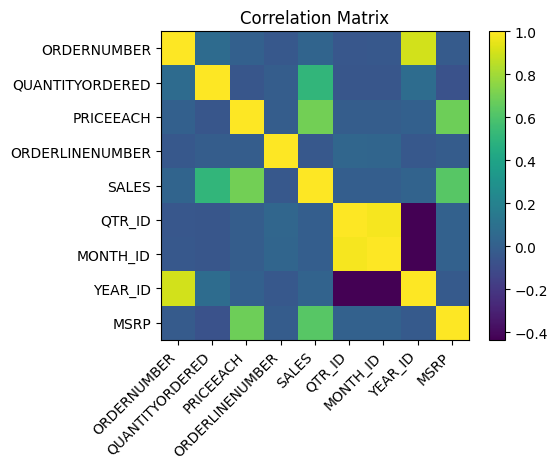

,ORDERNUMBER,QUANTITYORDERED,PRICEEACH,ORDERLINENUMBER,SALES,QTR_ID,MONTH_ID,YEAR_ID,MSRP
ORDERNUMBER,1.000000,0.066339,0.006681,-0.038906,0.030304,-0.045577,-0.037532,0.900764,-0.020672
QUANTITYORDERED,0.066339,1.000000,-0.050855,-0.009831,0.508955,-0.051240,-0.049160,0.072141,-0.071055
PRICEEACH,0.006681,-0.050855,1.000000,-0.011802,0.694613,-0.009691,-0.010753,0.005996,0.686122
ORDERLINENUMBER,-0.038906,-0.009831,-0.011802,1.000000,-0.039336,0.038192,0.031613,-0.041595,-0.019028
SALES,0.030304,0.508955,0.694613,-0.039336,1.000000,-0.004416,-0.004394,0.020585,0.624916
QTR_ID,-0.045577,-0.051240,-0.009691,0.038192,-0.004416,1.000000,0.979148,-0.433937,0.011998
MONTH_ID,-0.037532,-0.049160,-0.010753,0.031613,-0.004394,0.979148,1.000000,-0.434301,0.011059
YEAR_ID,0.900764,0.072141,0.005996,-0.041595,0.020585,-0.433937,-0.434301,1.000000,-0.027770
MSRP,-0.020672,-0.071055,0.686122,-0.019028,0.624916,0.011998,0.011059,-0.027770,1.000000


In [17]:
# Correlation matrix (numeric only)
num_df = df_scaled.select_dtypes(include=[np.number])
corr = num_df.corr(numeric_only=True)

plt.figure()
im = plt.imshow(corr.values, interpolation='nearest')
plt.title('Correlation Matrix')
plt.colorbar(im, fraction=0.046, pad=0.04)
plt.xticks(range(len(num_df.columns)), num_df.columns, rotation=45, ha='right')
plt.yticks(range(len(num_df.columns)), num_df.columns)
plt.tight_layout()
plt.savefig('screenshots/06_corr_matrix.png', bbox_inches='tight')
plt.show()

corr


In [18]:
# Save a normalized UTF-8 copy for future use
df.to_csv('sales_data_sample_utf8.csv', index=False, encoding='utf-8')
